In [76]:
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.utils import shuffle

In [77]:
# open docs file and read its lines
with open("train.dat", "r", encoding="utf8") as fh:
    lines = fh.readlines() 
print(len(lines))

8580


In [78]:
docs = list()
for row in lines:
    docs.append(row.rstrip().split(" "))

In [79]:

data = list()
occurence = list()
for dat in docs:
    data_index = list()
    occurence_index = list()
    for i in range(0, len(dat), 2):      
        data_index.append(int(dat[i]))
    for j in range(1, len(dat), 2):     
        occurence_index.append(int(dat[j]))
    data.append(data_index)
    occurence.append(occurence_index)

print(data[0])
print(occurence[0])

[1237, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 121, 1398, 1399, 205, 206, 369, 1400, 1401, 1402, 61, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 69, 210, 4, 6, 135, 533, 534, 618, 692, 1410, 1411, 1412, 1413, 1414, 1415, 1335, 1416, 1417, 1418, 78, 1419, 1096, 142, 540, 145, 308, 386, 864, 1420, 1421, 1422, 1423, 1424, 1182, 1425, 1426, 85, 1427, 1428, 1429, 710, 718, 955, 797, 1430, 1431, 1432, 1433, 1434, 1119, 1435, 1436, 1359, 1199, 722, 960, 169, 20, 22, 1125, 1360, 1126, 1361, 1362, 1363, 1364, 1283, 1365, 1366, 1367, 1368, 1369, 413, 570, 175, 338, 30, 1132, 1133, 35, 1370, 1371, 1138, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 105, 340, 262, 266, 668, 41, 46, 1380, 1309, 49, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 511, 117, 515]
[1, 1, 5, 3, 1, 4, 1, 1, 1, 1, 4, 2, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,

In [80]:
from collections import Counter
from scipy.sparse import csr_matrix
def build_matrix(docs):
    r""" Build sparse matrix from a list of documents, 
    each of which is a list of word/terms in the document.  
    """
    nrows = len(docs)
    idx = {}
    tid = 0
    nnz = 0
    for d in docs:
        nnz += len(set(d))
        for w in d:
            if w not in idx:
                idx[w] = tid
                tid += 1
    ncols = len(idx)
        
    # set up memory
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=np.int)
    i = 0  # document ID / row counter
    n = 0  # non-zero counter
    # transfer values
    for d in docs:
        cnt = Counter(d)
        keys = list(k for k,_ in cnt.most_common())
        l = len(keys)
        for j,k in enumerate(keys):
            ind[j+n] = idx[k]
            val[j+n] = cnt[k]
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
            
    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    
    return mat

In [81]:
mat = build_matrix(docs)

<ipython-input-80-ec85863f2b21>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind = np.zeros(nnz, dtype=np.int)
<ipython-input-80-ec85863f2b21>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

In [82]:
# scale matrix and normalize its rows
def csr_idf(mat, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v)) 
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat

In [83]:
def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat

In [84]:
def initialCentroids(matrix):
    matrixShuffled = shuffle(matrix, random_state=0)
    return matrixShuffled[:2,:]

In [85]:
mat2 = csr_idf(mat, copy=True)
mat3 = csr_l2normalize(mat2, copy=True)
mat3_pca = mat3.copy()
print(mat.shape)
print(mat3.shape)

(8580, 27673)
(8580, 27673)


In [86]:
# perform PCA decomposition on the data
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA(n_components=1500)
principalComponents = pca.fit_transform(mat3_pca.toarray())

In [69]:
mat3=principalComponents

In [70]:
def select_clusters(mat, centroids):
    
    c1 = list()
    c2 = list()
    
    similarityMatrix = mat.dot(centroids.T)
    for i in range(similarityMatrix.shape[0]):
        similarityRow = similarityMatrix[i]
        
        similaritySorted = np.argsort(similarityRow)[-1]
        
        if similaritySorted == 0:
            c1.append(i)
        else:
            c2.append(i)
        
    return c1, c2

In [ ]:
def recomputeCentroid(matrix, clusters):
    centroids = list()
    
    for i in range(0,2):
        cluster = matrix[clusters[i],:]
        clusterMean = cluster.mean(0)
        centroids.append(clusterMean)
        
    centroids_array = np.asarray(centroids)
    
    return centroids_array

In [71]:
from sklearn.cluster import KMeans

def kmeans(mat, n_iter):
    centroids = initialCentroids(mat)

    for _ in range(n_iter):
        clusters = list()
        c1, c2 = select_clusters(mat, centroids)
        
        if len(c1) > 1:
            clusters.append(c1)
        if len(c2) > 1:
            clusters.append(c2)
        
        centroids = recomputeCentroid(mat, clusters)
        
    return c1, c2

In [72]:
def calculateSSE(mat, clusters):
    
    sseList = list()
    sseArray = []
    for cluster in clusters:
        rmse = np.sum(np.square(mat[cluster,:] - np.mean(mat[cluster,:])))
        sseList.append(rmse)
    sseArray = np.asarray(sseList)
    remove_cluster_idx = np.argsort(sseArray)[-1]
    return remove_cluster_idx

In [73]:
from sklearn.cluster import KMeans
def bisecting_kmeans(mat, k, n_iter):
    
    clusters = list()
    
    initialcluster = list()
    # appending dimensions to initialcluster
    for i in range(mat.shape[0]):
        initialcluster.append(i)
    
    clusters.append(initialcluster)

    while len(clusters) < k:# 3

        remove_cluster_idx = calculateSSE(mat, clusters)
        removed_cluster = clusters[remove_cluster_idx]
        
        c1, c2 = kmeans(mat[removed_cluster,:], n_iter)
        del clusters[remove_cluster_idx]
        
        
        real_c1 = list()
        real_c2 = list()
        for index in c1:
            real_c1.append(removed_cluster[index])
            
        for index in c2:
            real_c2.append(removed_cluster[index])
        
        clusters.append(real_c1)
        clusters.append(real_c2)
    
    labels = [0] * mat.shape[0]

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index + 1
    return labels

In [74]:
from sklearn.metrics import silhouette_score
k_values = list()
scores = list()

for k in range(3, 21, 2):
    labels = bisecting_kmeans(mat3, k, 10)
    if (k == 7):        
        outputFile = open("output.dat", "w")
        for docuId, index in enumerate(labels, start=1):
            row = str(index)
            outputFile.write(row +'\n')
        outputFile.close()

    sscore = silhouette_score(mat3, labels)
    k_values.append(k)
    scores.append(sscore)
    print ("For K= %d silhouette_coefficient Score is %f" %(k, sscore))

For K= 3 silhouette_coefficient Score is 0.003022
For K= 5 silhouette_coefficient Score is -0.011180
For K= 7 silhouette_coefficient Score is -0.004333
For K= 9 silhouette_coefficient Score is -0.001380
For K= 11 silhouette_coefficient Score is -0.003256
For K= 13 silhouette_coefficient Score is -0.007835
For K= 15 silhouette_coefficient Score is -0.005160
For K= 17 silhouette_coefficient Score is -0.002862
For K= 19 silhouette_coefficient Score is -0.000889


Text(0, 0.5, 'Silhouette Score')

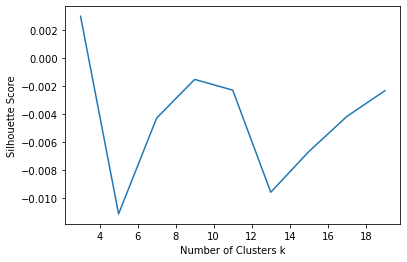

In [59]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.plot(k_values, scores)
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette Score')